In [1]:
import pydicom
import matplotlib.pyplot as plt
import os
import numpy as np
file_dir = os.path.dirname(os.getcwd()) # the directory that options.py resides in

print(file_dir)
root_dir = file_dir.split("/code")[0]
dataset_dir = root_dir+"/dataset"
dataset_dir

/home/mengyi/code


'/home/mengyi/dataset'

In [2]:
def MaxMinNormalizer(data):
    data_max = np.max(data)
    data_min = np.min(data)
    #print(data_max, data_min)
    data_normalize = (data - data_min) / (data_max - data_min)
    return data_normalize

def window_pixel_array(ds):
    pixel_array = ds.pixel_array
    if 'WindowWidth' in ds and 'WindowCenter' in ds:
        #print("defined")
        window_width = ds.WindowWidth
        window_center = ds.WindowCenter
        if isinstance(window_width, pydicom.valuerep.DSfloat):
            window_width = [window_width]
        if isinstance(window_center, pydicom.valuerep.DSfloat):
            window_center = [window_center]
    
        windowed_image = (pixel_array - (window_center[0] - window_width[0] / 2)) / window_width[0] * 255.0
        windowed_image = np.clip(windowed_image, 0, 255).astype(np.uint16)
    else:
        windowed_image = pixel_array
    
    return windowed_image

(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: '20220221'
(0008, 0013) Instance Creation Time              TM: '182826.294400'
(0008, 0016) SOP Class UID                       UI: Positron Emission Tomography Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.156.112605.159303470343965.220224102510.4.6352.42602
(0008, 0020) Study Date                          DA: '20211208'
(0008, 0021) Series Date                         DA: '20211208'
(0008, 0022) Acquisition Date                    DA: '20211208'
(0008, 0023) Content Date                        DA: '20220221'
(0008, 002a) Acquisition DateTime                DT: '20211208123040.7484'
(0008, 0030) Study Time                          TM: '122859'
(0008, 0031) Series Time                         TM: '123040.748400'
(0008, 0032) Acquisition Time                    TM: '12

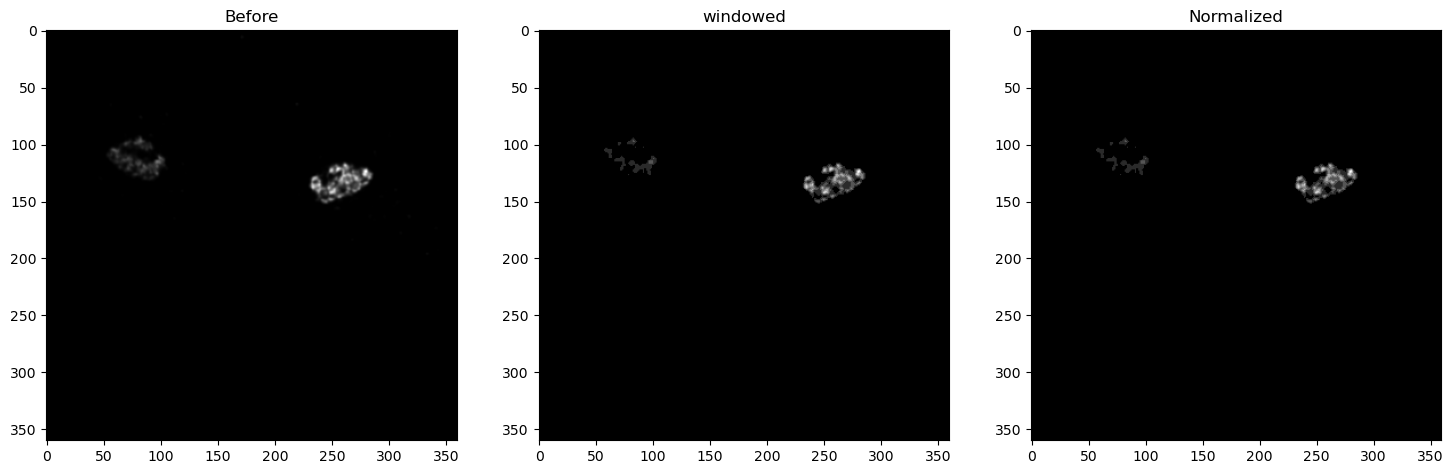

In [3]:
uExplorer_dir = "uExplorer/1st_uExplorer"
file_name = "Anonymous_ANO_20220224_1824561_122859/2.886 x 600 WB NORMAL/00000002.dcm"
full_file_name = os.path.join(dataset_dir, uExplorer_dir, file_name)
ds = pydicom.dcmread(full_file_name)
for elem in ds:
    print(elem)
print(ds.pixel_array)
ds.pixel_array.shape

pixel_array = ds.pixel_array

if 'WindowWidth' in ds and 'WindowCenter' in ds:
    print("WindowWidth and WindowCenter are defined.")
    window_width = ds.WindowWidth
    window_center = ds.WindowCenter
    if isinstance(window_width, pydicom.valuerep.DSfloat):
        window_width = [window_width]
    if isinstance(window_center, pydicom.valuerep.DSfloat):
        window_center = [window_center]
    
    windowed_image = (pixel_array - (window_center[0] - window_width[0] / 2)) / window_width[0] * 255.0
    windowed_image = np.clip(windowed_image, 0, 255).astype(np.uint16)
else:
    windowed_image = pixel_array

normalized_image = MaxMinNormalizer(windowed_image)

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(pixel_array, cmap="gray")
plt.title('Before')
plt.subplot(1,3,2)
plt.imshow(windowed_image, cmap="gray")
plt.title('windowed')
plt.subplot(1,3,3)
plt.imshow(normalized_image, cmap="gray")
plt.title('Normalized')
plt.show()

In [4]:
import matplotlib.image as mpimg
def transfer_png_anonymous_dir(directory, dose_req = "NORMAL", NORMALIZE = True):
    """
    Count the number of files in directories that start with 'Anonymous_' in the given directory.

    :param directory: Path to the directory to search in.
    :param dose_req: Dose to transfer to PNG.
    :param NORMALIZE: Whether normalize the image
    :return: Whether transfer succfully.
    """
    directory_name = directory.split("/")[-1]

    if directory_name.startswith('Anonymous_'):
        for folder_name in os.listdir(directory):
            dose_type = folder_name.split(" ")[-1]
            if dose_type == dose_req:
                for file_name in os.listdir(os.path.join(directory, folder_name)):
                    full_file_name = os.path.join(directory, folder_name, file_name)
                    ds = pydicom.dcmread(full_file_name)
                    pixel_array = ds.pixel_array
                    windowed_image = window_pixel_array(ds)
                    if NORMALIZE:
                        normalized_image = MaxMinNormalizer(windowed_image)
                        saved_image = normalized_image
                    else:
                        saved_image = windowed_image
                    saved_folder = os.path.join(dataset_dir,"uExplorer", "pngImage", dose_type)
                    if not os.path.exists(saved_folder ):
                        os.makedirs(saved_folder )
                    saved_name = dose_type+"_"+ directory_name+"_"+file_name.split(".")[0]+".png"
                    mpimg.imsave(os.path.join(saved_folder,saved_name), saved_image, cmap='gray')
        return True
    return False

In [9]:
transfer_number = 14
dose_req = "NORMAL"
NORMALIZE = False

dose_list = ["NORMAL", "D2", "D4", "D10", "D20", "D50", "D100"]
err_results = []
err_cnt = 0
tot_cnt = 0
for folder_name in sorted(os.listdir(os.path.join(dataset_dir, uExplorer_dir))):
    print('Dose: {}, Transfer {} to png...'.format(dose_req, folder_name))
    folder_path = os.path.join(dataset_dir, uExplorer_dir, folder_name)
    result = transfer_png_anonymous_dir(folder_path, dose_req, NORMALIZE)
    tot_cnt+=1
    if not result:
        err_results.append(tot_cnt)
        err_cnt+=1
    if tot_cnt >= transfer_number:
        break
print("Successfully transfer {} to png.".format(tot_cnt))
if err_cnt != 0:
    print("Failed to transfer {} to png. Failed number: {}".format(err_cnt, err_results))
    

Dose: D10, Transfer Anonymous_ANO_20220224_1824561_122859 to png...
Dose: D10, Transfer Anonymous_ANO_20220224_1826572_121743 to png...
Dose: D10, Transfer Anonymous_ANO_20220224_1828586_120633 to png...
Dose: D10, Transfer Anonymous_ANO_20220224_1831028_115350 to png...
Dose: D10, Transfer Anonymous_ANO_20220224_1833020_114003 to png...
Dose: D10, Transfer Anonymous_ANO_20220224_1835039_111917 to png...
Dose: D10, Transfer Anonymous_ANO_20220224_1837073_110801 to png...
Dose: D10, Transfer Anonymous_ANO_20220224_1839044_105624 to png...
Dose: D10, Transfer Anonymous_ANO_20220224_1841037_104500 to png...
Dose: D10, Transfer Anonymous_ANO_20220224_1843069_103247 to png...
Dose: D10, Transfer Anonymous_ANO_20220224_1845053_101824 to png...
Dose: D10, Transfer Anonymous_ANO_20220224_1847066_100500 to png...
Dose: D10, Transfer Anonymous_ANO_20220224_1849121_095111 to png...
Dose: D10, Transfer Anonymous_ANO_20220224_1851132_093851 to png...
Successfully transfer 14 to png.
